In [1]:
import sys
import re
import nltk
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print('Python: {}'.format(sys.version))
print('NLTK: {}'.format(nltk.__version__))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))

SyntaxError: invalid syntax (2974367496.py, line 7)

In [20]:
# Load the dataset
df = pd.read_csv('spam.csv', header=None, encoding="ISO-8859-1")

# Remove unnecessary columns and rows
df = df.iloc[:, :2]
df.columns = ['label', 'message']
df.dropna(inplace=True)

# Encode labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Check class distribution
print(df['label'].value_counts())

label
0.0    4825
1.0     747
Name: count, dtype: int64


In [21]:
def preprocess_text(text):
    # Replace email addresses, URLs, money symbols, numbers
    text = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', text)
    text = re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress', text)
    text = re.sub(r'£|\$', 'moneysymb', text)
    text = re.sub(r'\d+(\.\d+)?', 'numbr', text)
    text = re.sub(r'[^\w\d\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

# Apply text preprocessing
df['message'] = df['message'].apply(preprocess_text)

In [22]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    words = text.split()
    return ' '.join(lemmatizer.lemmatize(word) for word in words if word not in stop_words)

df['message'] = df['message'].apply(lemmatize_text)

In [23]:
# Use TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1500, stop_words='english')
X = vectorizer.fit_transform(df['message']).toarray()
y = df['label']

In [24]:
# Check for NaN in y
if pd.isnull(y).any():
    print("Found NaN in target variable. Removing corresponding rows...")
    df = df.dropna(subset=['label'])
    X = vectorizer.fit_transform(df['message']).toarray()
    y = df['label'].values

# Re-split the data after ensuring y has no NaN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Train and evaluate models
models = [
    ("Logistic Regression", LogisticRegression()),
    ("K Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("SGD Classifier", SGDClassifier(max_iter=1000)),
    ("Naive Bayes", MultinomialNB()),
    ("SVM", SVC(kernel='linear'))
]

results = {}
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    results[name] = acc
    print(f"{name} Accuracy: {acc:.2f}%")

Found NaN in target variable. Removing corresponding rows...
Logistic Regression Accuracy: 98.13%
K Nearest Neighbors Accuracy: 93.90%
Decision Tree Accuracy: 97.77%
Random Forest Accuracy: 98.92%
SGD Classifier Accuracy: 99.21%
Naive Bayes Accuracy: 98.85%
SVM Accuracy: 98.85%


In [25]:
ensemble = VotingClassifier(estimators=models, voting='hard')
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
ensemble_acc = accuracy_score(y_test, y_pred) * 100
results['Voting Classifier'] = ensemble_acc
print(f"Voting Classifier Accuracy: {ensemble_acc:.2f}%")

Voting Classifier Accuracy: 99.07%


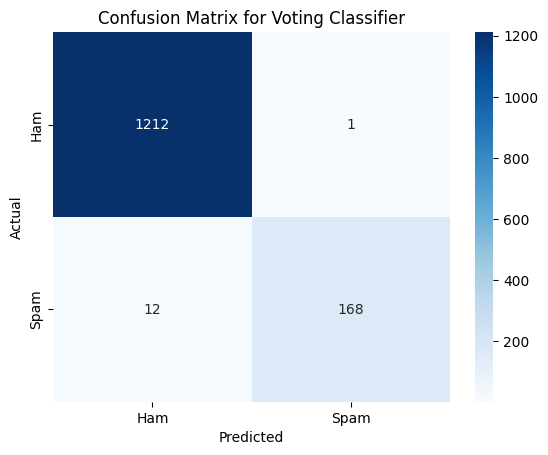

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1213
         1.0       0.99      0.93      0.96       180

    accuracy                           0.99      1393
   macro avg       0.99      0.97      0.98      1393
weighted avg       0.99      0.99      0.99      1393



In [26]:
# Confusion Matrix for Voting Classifier
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

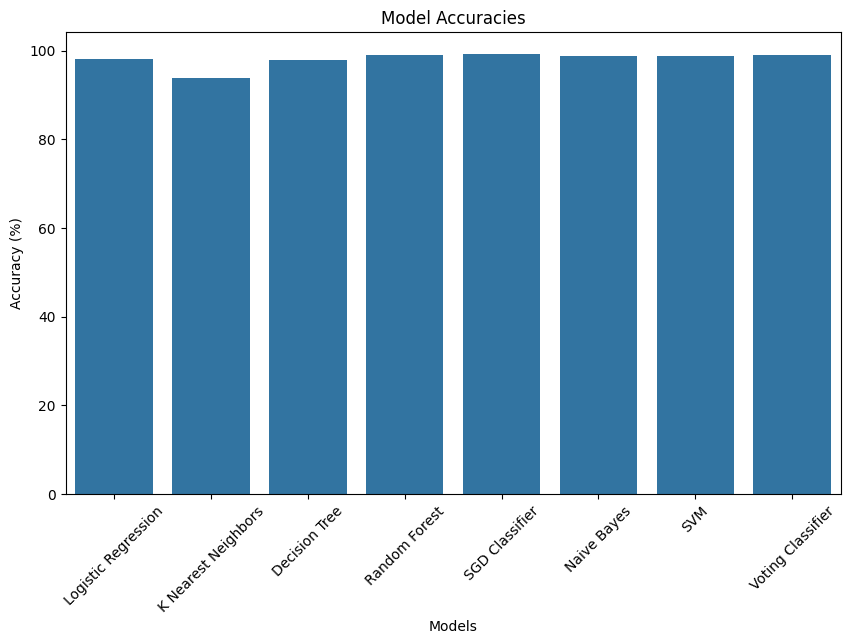

In [27]:
# Plot model accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracies")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.show()